# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(192387, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,192387.000000,192387.000000,192387.000000
mean,113937.905035,0.000135,145.026748
std,70999.561497,0.011624,4382.942031
min,21.000000,0.000000,0.000000
25%,49908.500000,0.000000,1.000000
50%,111144.000000,0.000000,3.000000
75%,173456.500000,0.000000,10.000000
max,242902.000000,1.000000,615354.000000


In [4]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거합니다.
petition_remove_outlier = petitions.loc[(petitions['votes'] > 100) & (petitions['votes'] < 10000)]
petition_remove_outlier.shape

(8235, 8)

In [5]:
df = petition_remove_outlier.copy()

In [6]:
df.describe()

,article_id,answered,votes
count,8235.000000,8235.0,8235.000000
mean,150340.415908,0.0,715.110383
std,67160.989853,0.0,1324.452564
min,28.000000,0.0,101.000000
25%,103623.500000,0.0,146.000000
50%,165952.000000,0.0,237.000000
75%,205690.500000,0.0,567.000000
max,242889.000000,0.0,9988.000000


# 이진분류 대상 정하기
* 답변 여부에 대해 분류해보는 실습을 해볼까 했지만 표준편차가 너무 크고 모수가 적어 분류 데이터로 적합하지 않습니다.

In [7]:
# 답변대상건이 몇 건인지 봅니다. 
df.loc[df['answered'] == 1].shape

(0, 8)

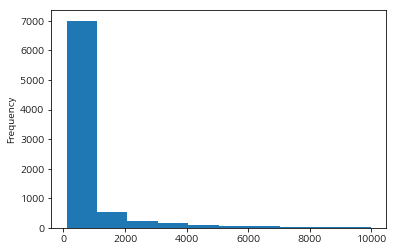

In [8]:
%matplotlib inline 
df['votes'].plot.hist()

# 투표수를 평균보다 높게 혹은 적게 받는지 예측해 보기

In [9]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

In [10]:
# 평균 투표수를 구해 옵니다.
votes_mean = df['votes'].mean()
votes_mean

715.1103825136612

In [11]:
# 투표수가 평균을 넘으면 1로 다시 세팅합니다.
df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [12]:
# 타입을 boolean 에서 int로 변경해 줍니다.
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

In [13]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0


In [14]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 38

In [15]:
sample_title = df['title'][sample_index]
sample_title

'영어회화전문강사제도는 유지되어야합니다.'

In [16]:
sample_content = petitions['content'][sample_index]
sample_content

'1. 영전강의고용안정을 원합니다\\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니다\\n3. 성과급 호봉인정 상여금 급식비지원 전혀없으며 연봉인상 또한 없습니다\\n4.인권위의 무기직으로 전환 권고받았습니다\\n5.공공부문 비정규직 없애는건 문정부의 공약이며 이에따라 영전강만 제외하는것은 불공평합니다\\n저희는 정교사나 정규직을 원하는것이 아닙니다.\\n이 일을 계속 하길 희망할 뿐입니다.  문재인대통령님께선 일자리창출을 매우 중요하게 생각하셨습니다.  일자리창출 만큼 중요한것이 일자리 유지입니다.  창출만 하고 유지가 되지 않는다면 그저  형식적인 정책일 뿐입니다. 하루빨리 결과가 나와  안정된 마음으로 일하고 싶습니다.  감사합니다.'

# 전처리 하기 

In [17]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [18]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [19]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [20]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [21]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 531 ms, sys: 7.6 ms, total: 539 ms
Wall time: 548 ms


In [22]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 1 s, sys: 9.58 ms, total: 1.01 s
Wall time: 1.02 s


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [23]:
df = df.reindex()

In [24]:
df.shape

(8235, 11)

In [25]:
split_count = int(df.shape[0] * 0.7)
split_count

5764

In [26]:
df_train = df[:split_count].copy()
df_train.shape

(5764, 11)

In [27]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은...
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0,국민의 이상이 황우석박사님을 응원하고 지지하고 있습니다 년 월 ...,국민의 이상이 황우석박사님을 응원하고 지지하고 년 중앙일보 여론...
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...


In [28]:
# 학습 세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(1348, 11)

In [29]:
df_test = df[split_count:].copy()
df_test.shape

(2471, 11)

In [30]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
163102,201588,2018-04-16,2018-05-16,0,723,육아/교육,수능정시확대 반대,제4차산업혁명시대에 대학교육이 바뀌어야 합니다.\n책이나 인터넷에 나오는 내용을 잘...,1,제 차산업혁명시대에 대학교육이 바뀌어야 합니다 책이나 인터넷에 나오는 내용을 잘 ...,차산업혁명시대에 대학교육이 바뀌어야 책이나 인터넷에 나오는 내용을 잘 활용하여 새...
163104,201590,2018-04-16,2018-05-16,0,176,외교/통일/국방,불어라!평화의봄바람:청소년이 남.북.미 정상에게 보내는 영상편지,"세상의 모든 봄이 한반도에 올 것 같은, 4월\n남측의 문재인 대통령\n북측의 김정...",0,세상의 모든 봄이 한반도에 올 것 같은 월 남측의 문재인 대통령 북측의 김정은 ...,세상의 모든 봄이 한반도에 올 것 남측의 문재인 대통령 북측의 김정은 위원장 미...
163108,201596,2018-04-16,2018-05-16,0,160,기타,대한항공 이름변경하게 해주세요,대한항공 자매들 나라망신 아닙니까?\n어디서 이런사람들한테 대한이라는 이름을 줍니까...,0,대한항공 자매들 나라망신 아닙니까 어디서 이런사람들한테 대한이라는 이름을 줍니까 ...,대한항공 자매들 나라망신 아닙니까 어디서 이런사람들한테 대한이라는 이름을 줍니까 ...
163121,201615,2018-04-16,2018-05-16,0,199,기타,대한항공 사태관련 국격훼손과 일가의 갑질.사명 회수등 강력요청.,뉴스를 볼때마다 울화통이 치밀어 오르네요. 해외뉴스에 연이어 나오며 나라망신을 시킨...,0,뉴스를 볼때마다 울화통이 치밀어 오르네요 해외뉴스에 연이어 나오며 나라망신을 시킨...,뉴스를 볼때마다 울화통이 치밀어 오르네요 해외뉴스에 연이어 나오며 나라망신을 시킨...
163129,201624,2018-04-16,2018-05-16,0,112,정치개혁,조선일보 폐지,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 하는 조신...,0,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 하는 조신...,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 조신일보는...


In [31]:
# 테스트 세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(365, 11)

# 단어 벡터화 하기

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 12 s, sys: 513 ms, total: 12.5 s
Wall time: 12.6 s


In [34]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 3.78 s, sys: 123 ms, total: 3.9 s
Wall time: 3.9 s


In [35]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'blog',
 'co',
 'co kr',
 'co kr news',
 'com',
 'com watch',
 'go',
 'go kr',
 'go kr petitions']

In [36]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,blog,co,co kr,co kr news,com,com watch,go,go kr,go kr petitions,...,후에,훨씬,휴게시간을,희망을,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,81,155,77,58,58,215,202,82,366,66,...,155,151,210,138,65,64,77,100,161,104


In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 14.2 ms, sys: 5.64 ms, total: 19.8 ms
Wall time: 20.4 ms


In [39]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 5.17 ms, sys: 2.47 ms, total: 7.64 ms
Wall time: 5.47 ms


In [40]:
test_feature_tfidf.shape

(2471, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [42]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 8.56 s, sys: 72.9 ms, total: 8.63 s
Wall time: 2.98 s


# 평가하기

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([0.78577624, 0.77103209, 0.76669558, 0.74848222, 0.74392361])

In [44]:
round(np.mean(score)*100,2)

76.32

# 예측

In [45]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
y_pred.shape

(2471,)

In [47]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [48]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['votes_pos_neg_pred'].value_counts()

0    2452
1      19
Name: votes_pos_neg_pred, dtype: int64

In [49]:
df_test['votes_pos_neg_pred'] = y_pred

In [50]:
df_test['pred_diff'] = df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred']
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2,votes_pos_neg_pred,pred_diff
163102,201588,2018-04-16,2018-05-16,0,723,육아/교육,수능정시확대 반대,제4차산업혁명시대에 대학교육이 바뀌어야 합니다.\n책이나 인터넷에 나오는 내용을 잘...,1,제 차산업혁명시대에 대학교육이 바뀌어야 합니다 책이나 인터넷에 나오는 내용을 잘 ...,차산업혁명시대에 대학교육이 바뀌어야 책이나 인터넷에 나오는 내용을 잘 활용하여 새...,0,1
163104,201590,2018-04-16,2018-05-16,0,176,외교/통일/국방,불어라!평화의봄바람:청소년이 남.북.미 정상에게 보내는 영상편지,"세상의 모든 봄이 한반도에 올 것 같은, 4월\n남측의 문재인 대통령\n북측의 김정...",0,세상의 모든 봄이 한반도에 올 것 같은 월 남측의 문재인 대통령 북측의 김정은 ...,세상의 모든 봄이 한반도에 올 것 남측의 문재인 대통령 북측의 김정은 위원장 미...,0,0
163108,201596,2018-04-16,2018-05-16,0,160,기타,대한항공 이름변경하게 해주세요,대한항공 자매들 나라망신 아닙니까?\n어디서 이런사람들한테 대한이라는 이름을 줍니까...,0,대한항공 자매들 나라망신 아닙니까 어디서 이런사람들한테 대한이라는 이름을 줍니까 ...,대한항공 자매들 나라망신 아닙니까 어디서 이런사람들한테 대한이라는 이름을 줍니까 ...,0,0
163121,201615,2018-04-16,2018-05-16,0,199,기타,대한항공 사태관련 국격훼손과 일가의 갑질.사명 회수등 강력요청.,뉴스를 볼때마다 울화통이 치밀어 오르네요. 해외뉴스에 연이어 나오며 나라망신을 시킨...,0,뉴스를 볼때마다 울화통이 치밀어 오르네요 해외뉴스에 연이어 나오며 나라망신을 시킨...,뉴스를 볼때마다 울화통이 치밀어 오르네요 해외뉴스에 연이어 나오며 나라망신을 시킨...,0,0
163129,201624,2018-04-16,2018-05-16,0,112,정치개혁,조선일보 폐지,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 하는 조신...,0,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 하는 조신...,김경수의원 의도적으로 정치적으로 의문점을 꼭 진행한것처럼 편향적인 보도를 조신일보는...,0,0


In [51]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

 0    2105
 1     356
-1      10
Name: pred_diff, dtype: int64

In [52]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 2471건의 데이터 중 2105건 예측


In [53]:
acc = ( pred_diff[0] / y_pred.shape[0] ) *100 
print('예측 비율 {}'.format(acc))

예측 비율 85.18818292189397
